# LOADING DATA

## Import Libraries

In [41]:

import os
import glob
import json
import numpy as np
import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,f1_score,accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MultiLabelBinarizer
import ast
from sklearn.preprocessing import OneHotEncoder

# Import necessary libraries
import lightgbm as lgb
import catboost as cb
import xgboost as xgb

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score  # or another appropriate metric

## Loading the data

In [42]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/new_test.csv")

# EDA

In [5]:
train.head()

,id,age,tenure,service_type,avg_call_duration,data_usage,roaming_usage,monthly_charge,overdue_payments,auto_payment,avg_top_up_count,call_drops,customer_support_calls,satisfaction_score,apps,churn
0,a34b17e3-792a-4ad9-9355-de5eb66db24a,35,236.0,Broadband,NaN,54.15,NaN,449.12,5,1.0,0,NaN,16,1.05,[],False
1,1a21c386-4b81-4b3b-981c-caaca3174d1a,18,290.0,Prepaid,NaN,103.61,21.48,1719.49,0,NaN,99,14.0,0,9.18,['Konuşalım'],False
2,5ff4f637-9eac-4fb7-aa6d-11d53bac2025,22,143.0,Broadband,NaN,NaN,NaN,345.51,0,1.0,0,NaN,13,7.08,['İzleGo'],False
3,ab8ec263-8323-45ca-bb7b-a4cb408db34d,25,214.0,Postpaid,67.60,169.18,21.15,659.27,2,1.0,0,13.0,8,6.88,[],False
4,e2f22d33-1c07-4805-b682-5ee24d8b858e,18,243.0,Prepaid,39.85,150.25,44.82,813.68,0,NaN,81,4.0,19,9.90,['RitimGo'],False


In [12]:
train.isnull().sum()

id                              0
age                             0
tenure                      19801
service_type                    0
avg_call_duration         2932038
data_usage                 399226
roaming_usage             2665686
monthly_charge             200211
overdue_payments                0
auto_payment              2676284
avg_top_up_count                0
call_drops                2665686
customer_support_calls          0
satisfaction_score              0
apps                            0
churn                           0
dtype: int64

In [10]:
histogram_columns = ["tenure","avg_call_duration","data_usage","roaming_usage","monthly_charge","satisfaction_score"]

discrete_columns = ["overdue_payments","auto_payment","call_drops","customer_support_calls"]

other_columns = ["avg_top_up_count","apps"]


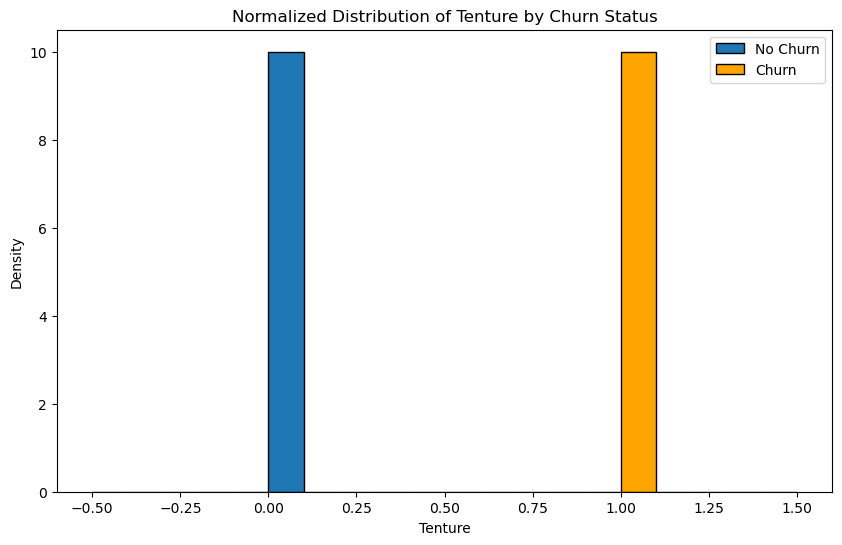

In [20]:
import matplotlib.pyplot as plt

column_name = "churn"

plt.figure(figsize=(10, 6))

# Plot histogram for non-churn customers
plt.hist(train[train['churn'] == 0][column_name],  
         label='No Churn', density=True, edgecolor='black')

# Plot histogram for churn customers
plt.hist(train[train['churn'] == 1][column_name], 
         label='Churn', density=True, edgecolor='black', color='orange')

plt.title('Normalized Distribution of Tenture by Churn Status')
plt.xlabel('Tenture')
plt.ylabel('Density')
plt.legend()
plt.show()


# Preprocessing

### modules

In [46]:
def filling_null_values(df):
        
    # Service Type:
    mask = (df['service_type'] == 'Prepaid') & (df['auto_payment'].isna())

    df.loc[mask, 'auto_payment'] = 0

    df["auto_payment"].fillna(0, inplace = True)

    # Create a mask for rows where customer_support_calls == 0 and avg_call_duration is null
    mask = (df['customer_support_calls'] == 0) & (df['avg_call_duration'].isna())

    # Update avg_call_duration to 0 for those rows
    df.loc[mask, 'avg_call_duration'] = 0

    # Fill 'tenure' and 'monthly_charge' with their median values
    df['tenure'].fillna(df['tenure'].median(), inplace=True)
    df['monthly_charge'].fillna(df['monthly_charge'].median(), inplace=True)

    # Function to fill missing values with uniform distribution within column range
    def fill_uniform(column):
        min_val = df[column].min()
        max_val = df[column].max()
        df[column] = df[column].apply(lambda x: np.random.uniform(min_val, max_val) if pd.isna(x) else x)

    # Fill 'avg_call_duration', 'data_usage', 'roaming_usage', and 'call_drops' with uniform distribution
    for col in ['avg_call_duration', 'data_usage', 'roaming_usage', 'call_drops']:
        fill_uniform(col)

    return df 

def drop_dirty_rows(df):
    
    return df

def feature_extraction(dff):
    df = dff.copy()

    eps = 1e-5  # Sıfır bölünmesini önlemek için

    df['total_call_duration'] = df['avg_call_duration'] * df['customer_support_calls']
    df['overdue_payment_ratio'] = df['overdue_payments'] / (df['tenure'] + eps)
    df['lifetime_value'] = df['monthly_charge'] * df['tenure']
    df['age_tenure_ratio'] = df['tenure'] / (df['age'] + eps)
    df['satisfaction_support'] = df['satisfaction_score'] / (df['customer_support_calls'] + eps)
    df['call_drop_ratio'] = np.where(
    df['customer_support_calls'] != 0,
    df['call_drops'] / df['customer_support_calls'],
    0  # or np.nan if you prefer to mark division-by-zero cases as missing
    )

    app_columns = ['İzleGo', 'RitimGo', 'CüzdanX', 'HızlıPazar', 'Konuşalım']
    df['total_apps_used'] = df[app_columns].sum(axis=1)

    return df




In [47]:
def preprocess(df,train = True,mlb = None,encoder = None):

    df = df.drop(columns=["id"],axis = 1)

    df = drop_dirty_rows(df)
    df = filling_null_values(df)

    df['apps'] = df['apps'].apply(ast.literal_eval)

    if train:
        # MultiLabelBinarizer for apps
        mlb = MultiLabelBinarizer()
        one_hot_apps = mlb.fit_transform(df['apps'])
        df_onehot = pd.DataFrame(one_hot_apps, columns=mlb.classes_, index=df.index)
        df_encoded = df.join(df_onehot)

        # Service type encoding
        encoder = OneHotEncoder(sparse_output = False)
        one_hot_encoded = encoder.fit_transform(df_encoded[['service_type']])
        # The column names are available in encoder.categories_[0]
        df_one_hot_new = pd.DataFrame(one_hot_encoded, columns=encoder.categories_[0], index=df_encoded.index)
        df_encoded_new = pd.concat([df_encoded, df_one_hot_new], axis=1)

    else:
        one_hot = mlb.transform(df['apps'])
        df_onehot = pd.DataFrame(one_hot, columns=mlb.classes_, index=df.index)
        df_encoded = df.join(df_onehot)

        one_hot_encoded = encoder.transform(df_encoded[['service_type']])
        df_one_hot_new = pd.DataFrame(one_hot_encoded, columns=encoder.categories_[0], index=df_encoded.index)
        df_encoded_new = pd.concat([df_encoded, df_one_hot_new], axis=1)

    df_encoded_new = df_encoded_new.drop(columns=["service_type","apps"],axis = 1)

    df_final = feature_extraction(df_encoded_new)
    return df_final,mlb,encoder

from sklearn.utils import resample
import pandas as pd


def undersample_data(X, y, majority_multiplier=5, random_state=42):
    
    # Combine X and y into a single DataFrame for easier manipulation.
    train_data = X.copy()
    train_data['target'] = y

    # Determine the counts for each class.
    target_counts = train_data['target'].value_counts()
    # Identify the minority class and its count.
    minority_class = target_counts.idxmin()
    minority_count = target_counts.min()

    # Define the desired sample sizes for each class.
    desired_counts = {}
    for cls, count in target_counts.items():
        if cls == minority_class:
            desired_counts[cls] = minority_count  # Keep all minority samples.
        else:
            desired_counts[cls] = majority_multiplier * minority_count  # Undersample majority.
    
    # Resample each class accordingly using sklearn's resample.
    resampled_list = []
    for cls in train_data['target'].unique():
        cls_data = train_data[train_data['target'] == cls]
        # Ensure we don't attempt to sample more than available.
        n_samples = min(desired_counts[cls], len(cls_data))
        cls_data_downsampled = resample(
            cls_data,
            replace=False,
            n_samples=n_samples,
            random_state=random_state
        )
        resampled_list.append(cls_data_downsampled)

    # Concatenate the resampled data for all classes.
    undersampled_data = pd.concat(resampled_list)

    # Shuffle the undersampled dataset to mix class samples.
    undersampled_data = undersampled_data.sample(frac=1, random_state=random_state).reset_index(drop=True)

    # Split back into X and y.
    X_res = undersampled_data.drop(columns=['target'])
    y_res = undersampled_data['target']

    return X_res, y_res

from imblearn.over_sampling import SMOTE

def oversample_data(X, y, random_state=42):
    print("Here1")
    """
    Oversamples the minority classes using SMOTE (Synthetic Minority Over-sampling Technique).

    Parameters:
        X (pd.DataFrame or np.ndarray): Feature data.
        y (pd.Series, np.ndarray, or list): Target labels.
        random_state (int): Random seed for reproducibility.

    Returns:
        X_res (pd.DataFrame or np.ndarray): Features after SMOTE oversampling.
        y_res (pd.Series or np.ndarray): Target labels after SMOTE oversampling.
    """
    # Initialize SMOTE object.
    smote = SMOTE(random_state=random_state)
    
    # Apply SMOTE to generate synthetic samples for minority classes.
    X_res, y_res = smote.fit_resample(X, y)
    print("Here2")
    return X_res, y_res


In [48]:
def print_all_metrics(preds,preds_proba,true):
    
    acc = accuracy_score(true, preds)
    cm = confusion_matrix(true, preds)
    precision = precision_score(true, preds)
    recall = recall_score(true, preds)
    f1 = f1_score(true, preds)  
    auc = roc_auc_score(true, preds_proba)

    print("Accuracy:",acc)
    print("Precision:", precision)  
    print("Recall:", recall)        
    print("F1 Score:", f1)
    print("auc:", auc)
    print("cm:", cm)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()



### implement preprocessing

In [49]:
processed_train,mlb,encoder = preprocess(train)
processed_test,_,_ = preprocess(test,train = False,mlb = mlb,encoder = encoder)

/var/folders/ny/ptyn1d2s7tnd17jl0vwnb_l40000gn/T/ipykernel_59627/148904959.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["auto_payment"].fillna(0, inplace = True)
/var/folders/ny/ptyn1d2s7tnd17jl0vwnb_l40000gn/T/ipykernel_59627/148904959.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

In [51]:
x_train = processed_train.drop(columns=["churn"],axis = 1)
y_train = processed_train["churn"]

x_test = processed_test.drop(columns=["churn"],axis = 1)
y_test = processed_test["churn"]

In [52]:
x_train.isnull().sum()

age                       0
tenure                    0
avg_call_duration         0
data_usage                0
roaming_usage             0
monthly_charge            0
overdue_payments          0
auto_payment              0
avg_top_up_count          0
call_drops                0
customer_support_calls    0
satisfaction_score        0
CüzdanX                   0
HızlıPazar                0
Konuşalım                 0
RitimGo                   0
İzleGo                    0
Broadband                 0
Postpaid                  0
Prepaid                   0
total_call_duration       0
overdue_payment_ratio     0
lifetime_value            0
age_tenure_ratio          0
satisfaction_support      0
call_drop_ratio           0
total_apps_used           0
dtype: int64

# Model evaluation

## Cross Validation

### LGB

In [15]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold

# Define your LightGBM parameters
lgb_params = {
    "objective": "binary",
    "boosting_type": "gbdt",
    'n_estimators': 309,
    'learning_rate': 0.01716029728096218,
    'num_leaves': 22,
    'max_depth': 6, 
    'min_child_samples': 10, 
    'subsample': 0.737440646376928,
    'colsample_bytree': 0.9862597807809604,
    'reg_alpha': 8.985515005642144e-07, 
    'reg_lambda': 1.00016444438518084528, 
    "random_state": 42,   
    "verbose": -1,
    "n_jobs": -1  
}

# Initialize StratifiedKFold with 5 splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Prepare lists to collect metrics for each fold
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
roc_auc_list = []
conf_matrix_list = []

# List to store the trained models from each fold
models = []

# Loop over each fold
for fold, (train_index, val_index) in enumerate(skf.split(x_train, y_train), 1):
    # Split the dataset into training and validation folds
    X_train_fold = x_train.iloc[train_index]
    y_train_fold = y_train.iloc[train_index]
    X_val_fold = x_train.iloc[val_index]
    y_val_fold = y_train.iloc[val_index]
    
    # Apply undersampling only on the training fold
    X_train_res, y_train_res = undersample_data(X_train_fold, y_train_fold,majority_multiplier=5,random_state=42)
    
    # Initialize a new model instance for this fold
    model = lgb.LGBMClassifier(**lgb_params)
    
    # Fit the model on the undersampled training data
    model.fit(X_train_res, y_train_res)
    
    # Store the trained model in the list
    models.append(model)
    
    # Predict on the validation fold
    y_val_pred = model.predict(X_val_fold)
    y_val_proba = model.predict_proba(X_val_fold)[:, 1]  # probability for the positive class

    # Compute evaluation metrics
    acc = accuracy_score(y_val_fold, y_val_pred)
    prec = precision_score(y_val_fold, y_val_pred)
    rec = recall_score(y_val_fold, y_val_pred)
    f1 = f1_score(y_val_fold, y_val_pred)
    roc_auc = roc_auc_score(y_val_fold, y_val_proba)
    conf_matrix = confusion_matrix(y_val_fold, y_val_pred)

    # Print fold metrics
    print(f"Fold {fold}:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall: {rec:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}\n")
    print(f"  Confusion Matrix: {conf_matrix}\n")
    
    # Store metrics for averaging later
    accuracy_list.append(acc)
    precision_list.append(prec)
    recall_list.append(rec)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)
    conf_matrix_list.append(conf_matrix)

# Calculate and print average metrics across all folds
print("Average metrics across folds:")
print(f"  Accuracy: {np.mean(accuracy_list):.4f}")
print(f"  Precision: {np.mean(precision_list):.4f}")
print(f"  Recall: {np.mean(recall_list):.4f}")
print(f"  F1 Score: {np.mean(f1_list):.4f}")
print(f"  ROC AUC: {np.mean(roc_auc_list):.4f}")



Fold 1:
  Accuracy: 0.9755
  Precision: 0.0912
  Recall: 0.0926
  F1 Score: 0.0919
  ROC AUC: 0.7995

  Confusion Matrix: [[1558865   19751]
 [  19403    1981]]

Fold 2:
  Accuracy: 0.9753
  Precision: 0.0888
  Recall: 0.0913
  F1 Score: 0.0900
  ROC AUC: 0.7979

  Confusion Matrix: [[1558582   20034]
 [  19432    1952]]



KeyboardInterrupt: 

## Training

### LGB

In [ ]:
x_train_res, y_train_res = undersample_data(x_train, y_train, majority_multiplier=5, random_state=42)
lgb_params = { "objective": "binary",
                  "boosting_type": "gbdt",
                    'n_estimators': 309,
                      'learning_rate': 0.01716029728096218,
                        'num_leaves': 22,
                          'max_depth': 6, 
                          'min_child_samples': 10, 
                          'subsample': 0.737440646376928,
                            'colsample_bytree': 0.9862597807809604,
                              'reg_alpha': 8.985515005642144e-07, 
                              'reg_lambda': 1.00016444438518084528, 
                    "random_state": 42,   
                    "verbose":100,
                    "n_jobs": -1  }

lgb_classifier = lgb.LGBMClassifier(**lgb_params)
lgb_classifier.fit(x_train_res, y_train_res)


[LightGBM] [Info] Number of positive: 106922, number of negative: 534610
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.867672
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.285362
[LightGBM] [Debug] init for col-wise cost 0.008256 seconds, init for row-wise cost 0.048874 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 3522
[LightGBM] [Info] Number of data points in the train set: 641532, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 6
[Light

LGBMClassifier(colsample_bytree=0.9862597807809604,
               learning_rate=0.01716029728096218, max_depth=6,
               min_child_samples=10, n_estimators=309, n_jobs=-1, num_leaves=22,
               objective='binary', random_state=42,
               reg_alpha=8.985515005642144e-07, reg_lambda=1.000164444385181,
               subsample=0.737440646376928, verbose=100)

## Evaluation on test set

### LGB

Accuracy: 0.9752305
Precision: 0.09028526262844004
Recall: 0.09401069918820845
F1 Score: 0.09211032713277742
auc: 0.7988360693082897
cm: [[1947948   25321]
 [  24218    2513]]


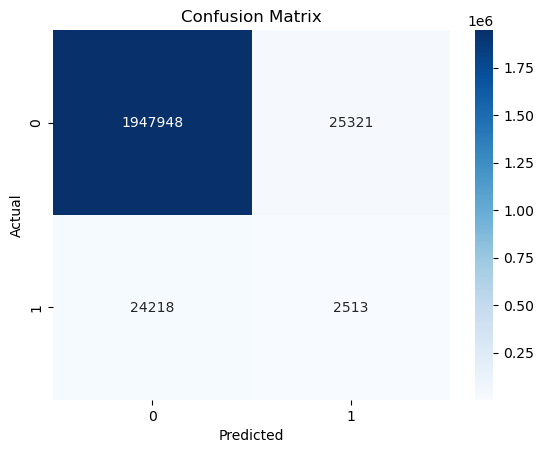

In [29]:
y_pred = lgb_classifier.predict(x_test)
y_pred_proba = lgb_classifier.predict_proba(x_test)[:, 1]

cm = print_all_metrics(y_pred,y_pred_proba,y_test)


# PostProcessing

### LGB optuna

[I 2025-02-07 17:04:35,526] A new study created in memory with name: no-name-4bc367dc-bd58-411a-aa0a-e3995ea688a3


Accuracy: 0.975281
Precision: 0.09035144692213322
Recall: 0.09367050725721981
F1 Score: 0.09198104543951806
auc: 0.7984545549233166
cm: [[974029  12605]
 [ 12114   1252]]


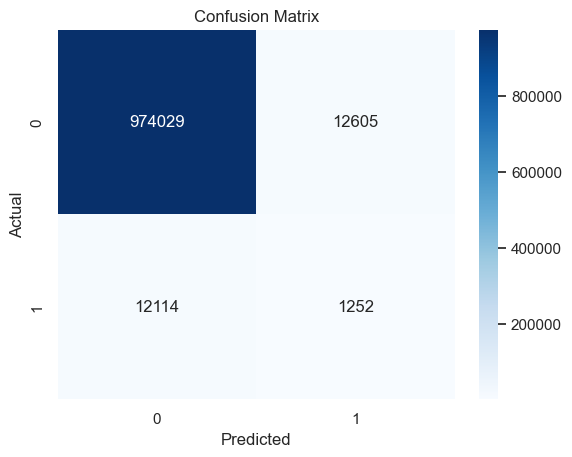

[I 2025-02-07 17:05:08,110] Trial 0 finished with value: 0.09198104543951806 and parameters: {'n_estimators': 1069, 'learning_rate': 0.020199094325224994, 'num_leaves': 20, 'max_depth': 9, 'min_child_samples': 28, 'subsample': 0.7083062292786696, 'colsample_bytree': 0.7275575506804631, 'reg_alpha': 3.298815602974688e-05, 'reg_lambda': 6.457907512834074e-06}. Best is trial 0 with value: 0.09198104543951806.


Accuracy: 0.974844
Precision: 0.08862526168876483
Recall: 0.09501720784079007
F1 Score: 0.09170999422299249
auc: 0.7976359596055325
cm: [[973574  13060]
 [ 12096   1270]]


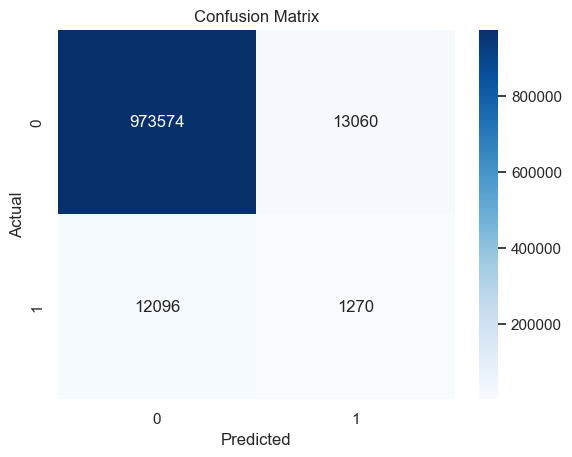

[I 2025-02-07 17:05:45,874] Trial 1 finished with value: 0.09170999422299249 and parameters: {'n_estimators': 1430, 'learning_rate': 0.07184951403537886, 'num_leaves': 23, 'max_depth': 3, 'min_child_samples': 44, 'subsample': 0.9018205156751866, 'colsample_bytree': 0.8792609633857374, 'reg_alpha': 0.008114249086148741, 'reg_lambda': 5.347215310653969e-05}. Best is trial 0 with value: 0.09198104543951806.


Accuracy: 0.975339
Precision: 0.09049380030454644
Recall: 0.09337124046087086
F1 Score: 0.09191000478697942
auc: 0.79816950561565
cm: [[974091  12543]
 [ 12118   1248]]


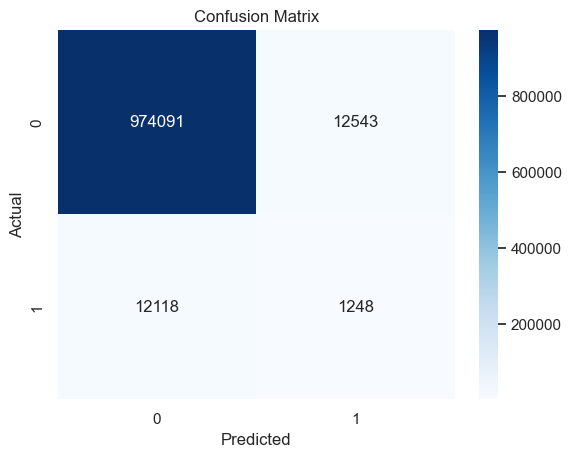

[I 2025-02-07 17:05:58,792] Trial 2 finished with value: 0.09191000478697942 and parameters: {'n_estimators': 228, 'learning_rate': 0.01674531556795686, 'num_leaves': 40, 'max_depth': 8, 'min_child_samples': 39, 'subsample': 0.8547735182575409, 'colsample_bytree': 0.75198858677037, 'reg_alpha': 1.5148377334495313, 'reg_lambda': 1.409754737001261e-07}. Best is trial 0 with value: 0.09198104543951806.


Accuracy: 0.975202
Precision: 0.08995695839311334
Recall: 0.09382014065539429
F1 Score: 0.09184794550648209
auc: 0.7982508549766983
cm: [[973948  12686]
 [ 12112   1254]]


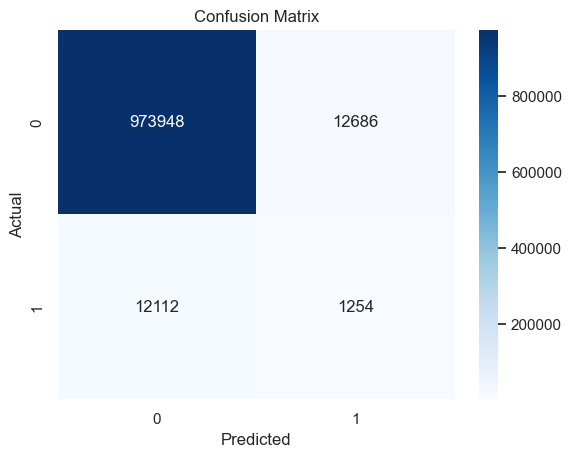

[I 2025-02-07 17:06:23,591] Trial 3 finished with value: 0.09184794550648209 and parameters: {'n_estimators': 649, 'learning_rate': 0.03187759927179959, 'num_leaves': 31, 'max_depth': 10, 'min_child_samples': 14, 'subsample': 0.9837552033010617, 'colsample_bytree': 0.8062453127926033, 'reg_alpha': 0.06894138744118344, 'reg_lambda': 1.1168821354361574e-08}. Best is trial 0 with value: 0.09198104543951806.


Accuracy: 0.975246
Precision: 0.09006479481641469
Recall: 0.09359569055813258
F1 Score: 0.0917963017317288
auc: 0.7979088247367372
cm: [[973995  12639]
 [ 12115   1251]]


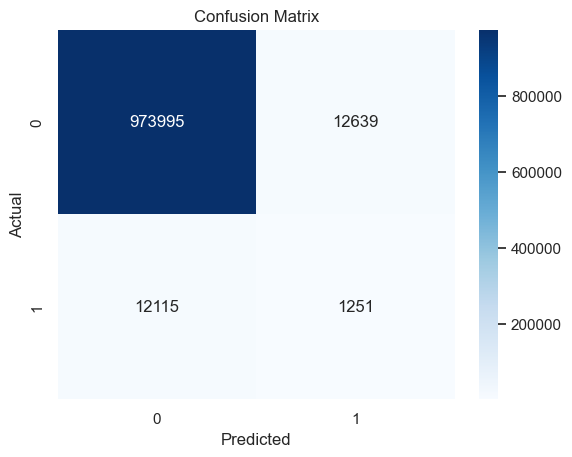

[I 2025-02-07 17:07:08,261] Trial 4 finished with value: 0.0917963017317288 and parameters: {'n_estimators': 957, 'learning_rate': 0.02240321947536288, 'num_leaves': 43, 'max_depth': 5, 'min_child_samples': 31, 'subsample': 0.7654581291962247, 'colsample_bytree': 0.8168888940597304, 'reg_alpha': 6.764350766994073, 'reg_lambda': 0.0003653232382711377}. Best is trial 0 with value: 0.09198104543951806.


Accuracy: 0.974716
Precision: 0.08681181528220774
Recall: 0.09367050725721981
F1 Score: 0.09011083921117029
auc: 0.7978577902227708
cm: [[973464  13170]
 [ 12114   1252]]


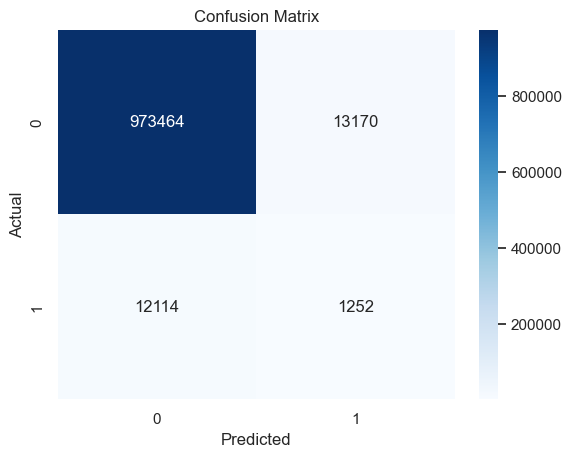

[I 2025-02-07 17:07:44,578] Trial 5 finished with value: 0.09011083921117029 and parameters: {'n_estimators': 1311, 'learning_rate': 0.07788253713108607, 'num_leaves': 28, 'max_depth': 3, 'min_child_samples': 30, 'subsample': 0.7019447683838588, 'colsample_bytree': 0.9908840450931942, 'reg_alpha': 0.0002718546478618769, 'reg_lambda': 1.9394176923373444e-05}. Best is trial 0 with value: 0.09198104543951806.


Accuracy: 0.973534
Precision: 0.08285568717360846
Recall: 0.09733652551249439
F1 Score: 0.08951424246594193
auc: 0.7972722330051163
cm: [[972233  14401]
 [ 12065   1301]]


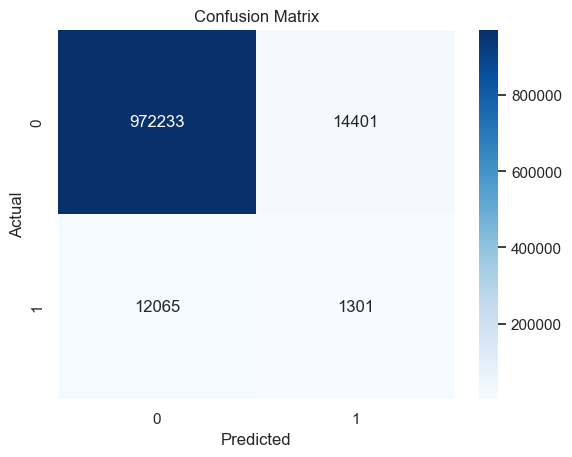

[I 2025-02-07 17:08:42,151] Trial 6 finished with value: 0.08951424246594193 and parameters: {'n_estimators': 1481, 'learning_rate': 0.04593816638370144, 'num_leaves': 29, 'max_depth': 7, 'min_child_samples': 45, 'subsample': 0.7074036667517307, 'colsample_bytree': 0.8517107775249555, 'reg_alpha': 7.129040185111429e-07, 'reg_lambda': 3.2112787376190415}. Best is trial 0 with value: 0.09198104543951806.


Accuracy: 0.975211
Precision: 0.09019157637942168
Recall: 0.09404459075265599
F1 Score: 0.09207779364904956
auc: 0.7981839116941545
cm: [[973954  12680]
 [ 12109   1257]]


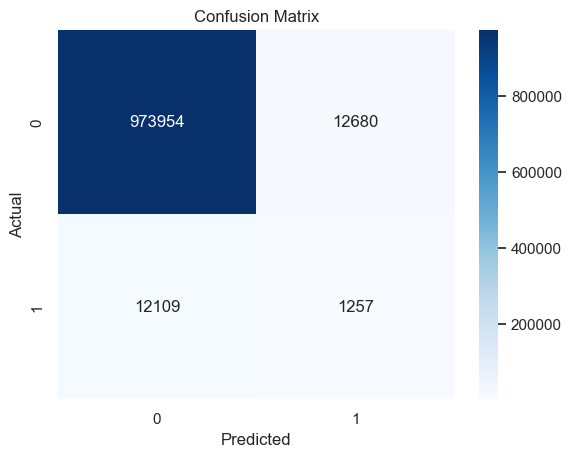

[I 2025-02-07 17:09:41,867] Trial 7 finished with value: 0.09207779364904956 and parameters: {'n_estimators': 1170, 'learning_rate': 0.017307394847376534, 'num_leaves': 32, 'max_depth': 5, 'min_child_samples': 47, 'subsample': 0.8820272962491129, 'colsample_bytree': 0.8793114002570276, 'reg_alpha': 2.3867994735963864e-06, 'reg_lambda': 1.6423043262268617e-07}. Best is trial 7 with value: 0.09207779364904956.


Accuracy: 0.975086
Precision: 0.08973994599971578
Recall: 0.0944934909471794
F1 Score: 0.09205539358600583
auc: 0.798058589434983
cm: [[973823  12811]
 [ 12103   1263]]


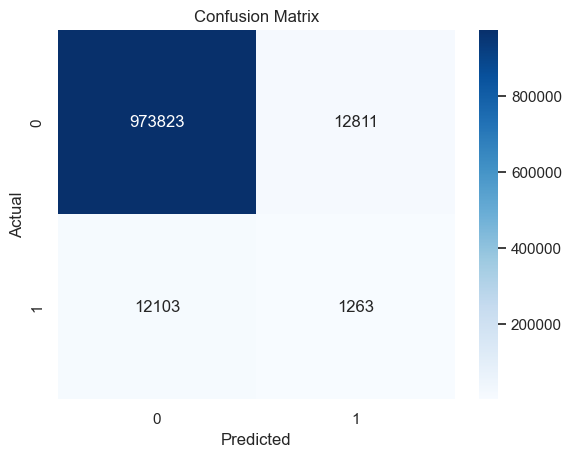

[I 2025-02-07 17:10:09,207] Trial 8 finished with value: 0.09205539358600583 and parameters: {'n_estimators': 819, 'learning_rate': 0.040665239959192793, 'num_leaves': 22, 'max_depth': 8, 'min_child_samples': 25, 'subsample': 0.92222428649627, 'colsample_bytree': 0.9398235420283401, 'reg_alpha': 0.000144775064349058, 'reg_lambda': 0.7835148603869116}. Best is trial 7 with value: 0.09207779364904956.


Accuracy: 0.975478
Precision: 0.09063554968442683
Recall: 0.0923986233727368
F1 Score: 0.09150859513930053
auc: 0.7981010535386983
cm: [[974243  12391]
 [ 12131   1235]]


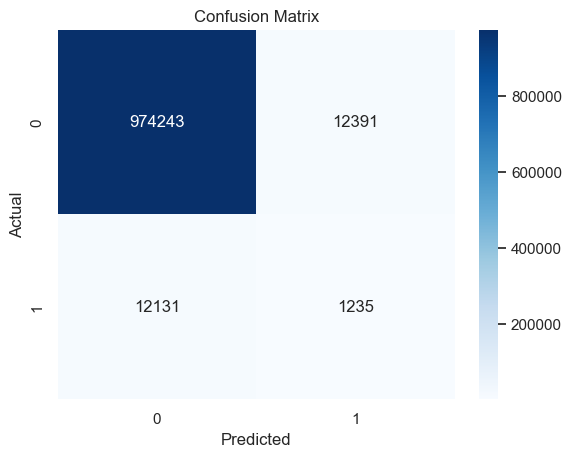

[I 2025-02-07 17:10:24,647] Trial 9 finished with value: 0.09150859513930053 and parameters: {'n_estimators': 311, 'learning_rate': 0.01196148491738121, 'num_leaves': 20, 'max_depth': 7, 'min_child_samples': 40, 'subsample': 0.7536816747055917, 'colsample_bytree': 0.6873117598456991, 'reg_alpha': 0.0005153020454937134, 'reg_lambda': 0.004816726096338321}. Best is trial 7 with value: 0.09207779364904956.


Accuracy: 0.975337
Precision: 0.09048067860508954
Recall: 0.09337124046087086
F1 Score: 0.0919032364961891
auc: 0.7981201668555633
cm: [[974089  12545]
 [ 12118   1248]]


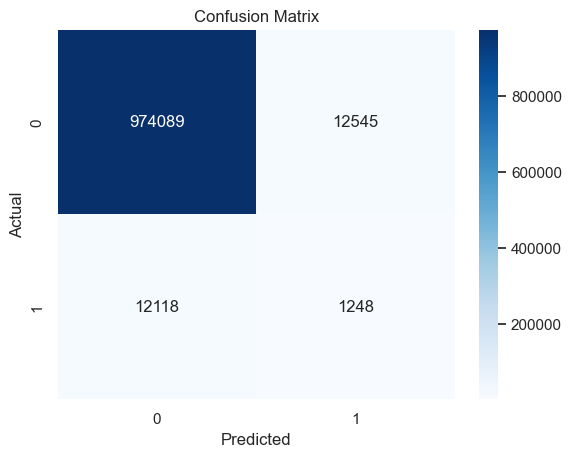

[I 2025-02-07 17:10:54,948] Trial 10 finished with value: 0.0919032364961891 and parameters: {'n_estimators': 575, 'learning_rate': 0.01005813248560256, 'num_leaves': 48, 'max_depth': 5, 'min_child_samples': 50, 'subsample': 0.8316365774286807, 'colsample_bytree': 0.6010924225392429, 'reg_alpha': 1.1887492784402807e-08, 'reg_lambda': 6.190050488481481e-07}. Best is trial 7 with value: 0.09207779364904956.


Accuracy: 0.974601
Precision: 0.08788273169395164
Recall: 0.09598982492892413
F1 Score: 0.09175755408546397
auc: 0.7975111741865886
cm: [[973318  13316]
 [ 12083   1283]]


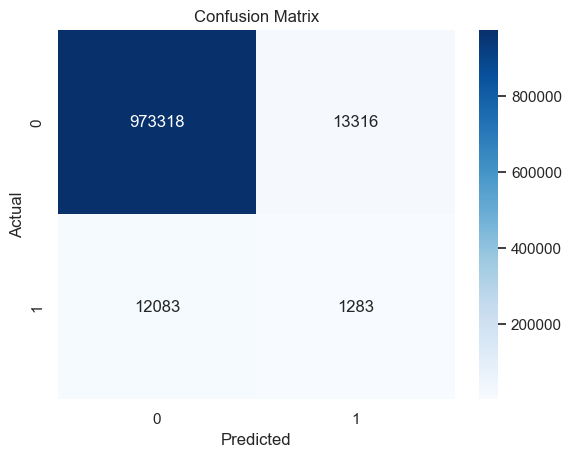

[I 2025-02-07 17:11:43,601] Trial 11 finished with value: 0.09175755408546397 and parameters: {'n_estimators': 1102, 'learning_rate': 0.040377504789323566, 'num_leaves': 36, 'max_depth': 5, 'min_child_samples': 19, 'subsample': 0.9448388817145054, 'colsample_bytree': 0.9444740860368843, 'reg_alpha': 2.6356931610813373e-06, 'reg_lambda': 2.0480581922746817}. Best is trial 7 with value: 0.09207779364904956.


Accuracy: 0.974236
Precision: 0.08601576065179645
Recall: 0.09636390842436032
F1 Score: 0.09089625970359916
auc: 0.7977967710644627
cm: [[972948  13686]
 [ 12078   1288]]


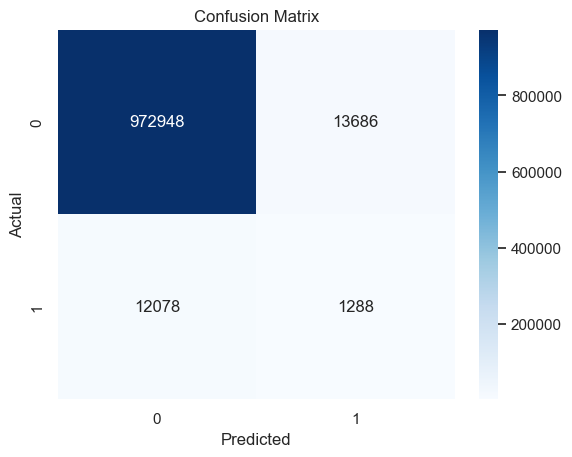

[I 2025-02-07 17:12:16,391] Trial 12 finished with value: 0.09089625970359916 and parameters: {'n_estimators': 821, 'learning_rate': 0.05115405192738944, 'num_leaves': 26, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.6012326853975243, 'colsample_bytree': 0.9255095487200273, 'reg_alpha': 2.1977211933562137e-07, 'reg_lambda': 0.05340171558622164}. Best is trial 7 with value: 0.09207779364904956.
[W 2025-02-07 17:12:32,254] Trial 13 failed with parameters: {'n_estimators': 1183, 'learning_rate': 0.026665252819446567, 'num_leaves': 35, 'max_depth': 8, 'min_child_samples': 34, 'subsample': 0.9012512696452473, 'colsample_bytree': 0.9020318774394555, 'reg_alpha': 1.3114769315673066e-05, 'reg_lambda': 0.10840013782573037} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/cekubalp/anaconda3/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^

KeyboardInterrupt: 

In [ ]:
import optuna

def objective(trial):
    # Define hyperparameters to tune via Optuna
    lgb_params = {
        "objective": "binary",
        "boosting_type": "gbdt",
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1,log = True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1e-1,log = True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1e-1, log = True),
        "random_state": 42,
        "verbose": -1,
        "n_jobs": -1
    }
    
    # Use StratifiedKFold for cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_score_list = []
    
    for train_index, val_index in skf.split(x_train, y_train):
        X_train_fold = x_train.iloc[train_index]
        y_train_fold = y_train.iloc[train_index]
        X_val_fold = x_train.iloc[val_index]
        y_val_fold = y_train.iloc[val_index]
        
        # Apply undersampling on the training fold
        X_train_res, y_train_res = undersample_data(X_train_fold, y_train_fold, majority_multiplier=5, random_state=42)
        
        # Initialize and train the model
        model = lgb.LGBMClassifier(**lgb_params)
        model.fit(X_train_res, y_train_res)
        
        # Predict probabilities on the validation fold
        y_val_proba = model.predict_proba(X_val_fold)[:, 1]
        y_val = model.predict(X_val_fold)
        f1_score_ = f1_score(y_val_fold, y_val)
        f1_score_list.append(f1_score_)
    
    # Return the average ROC AUC across folds as the objective to maximize
    avg_f1_score = np.mean(f1_score_list)
    return avg_f1_score

# Create and run the Optuna study (here, we run 50 trials; adjust n_trials as needed)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("\nBest trial:")
best_trial = study.best_trial
print(f"  ROC AUC: {best_trial.value:.4f}")
print("  Best hyperparameters:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

best_params = best_trial.params

## Feature importance

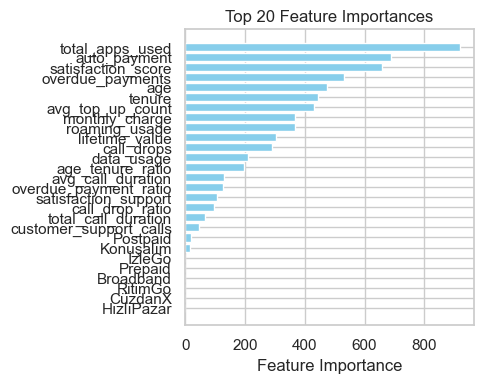

In [ ]:
feature_importances = lgb_classifier.feature_importances_
# Match them to the column names
feature_names = x_train.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Select the top 20 features
top_features = importance_df

# Create a horizontal bar chart
plt.figure(figsize=(5, 4))
plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Top 20 Feature Importances")
plt.gca().invert_yaxis()  # Invert y-axis so the highest importance is on top
plt.tight_layout()
plt.show()


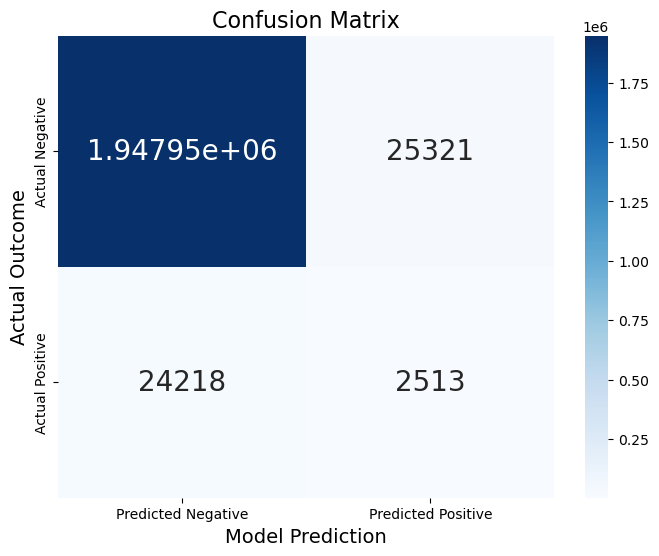

In [32]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the confusion matrix
cm = np.array([[1947948, 25321],
               [24218, 2513]])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'],
            annot_kws={"size": 20})  # Increase the annotation text size

plt.xlabel('Model Prediction', fontsize=14)
plt.ylabel('Actual Outcome', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

# Save the image to a file named 'confusion_matrix.png'
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')

plt.show()
